Manually fit parameters

In [3]:
# Import the necessary packages
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.integrate import odeint
import pandas as pd
from scipy.stats import linregress

In [27]:
# No changes are needed for this cell.
figSize=600

# Let's define a simple function that computes the time of the next reaction given our propensity functions:
def next_time(x, t, W_SSA, pars, di, ti):
    return -np.log(np.random.rand()) / np.sum(W_SSA(x, t, pars, di, ti))

# Let's define a simple function that computes the index of the next reaction given our propensity functions:
def next_reaction(x, t, W_SSA, pars, di, ti):
    W = W_SSA(x, t, pars, di, ti)
    W0 = np.sum(W)
    r = np.random.rand()
    i = 0
    W_sum = W[0]
    while W_sum / W0 < r:
        i += 1
        W_sum += W[i]
    return i

def gillespie_drugs(x0, t0, tmax, S, W_SSA, pars, di, ti, returnFullTraj = False):
    # Initialize the time and the state
    t = t0
    x = np.array(x0)
    S = np.array(S)
    
    # Initialize the output (if requested)
    if returnFullTraj:
        times = [t0]
        states = [x0]
    
    # Run the simulation
    while t < tmax:

        # Compute the time of the next reaction
        tau = next_time(x, t, W_SSA, pars, di, ti)
        t += tau
        
        # Exit the loop if the next reaction is beyond tmax
        if t > tmax:
            break
        
        # Compute the index of the next reaction
        i = next_reaction(x, t, W_SSA, pars, di, ti)
        # Update the state
        x = x + S[:, i]
        
        # Append the results (if requested)
        if returnFullTraj:
            times.append(t)
            states.append(x)

    # Return the results
    if returnFullTraj:
        # Return the full trajectory
        return np.array(times), np.array(states)
    else:
        # Return only the final state
        return x
    
def dxdt(x, t, pars, di, ti):
    x = np.atleast_2d(x).T
    y = (S @ W_ODE(x, t, pars, di, ti)).flatten()
    return y


def solve(S, W_ODE, W_SSA, x0, t, pars, di, ti, model='ODE', ntraj=1):

    if model == 'ODE':
        trajectory = odeint(dxdt,np.array(x0),t, args=(pars, di, ti))

    if model == 'SSA':
        trajectory = np.zeros([ntraj, len(t), len(x0)])
        t0 = t[0]
        tmax = t[-1]
        for i in range(ntraj):
            times,states = gillespie_drugs(x0, t0, tmax, S, W_SSA, pars, di, ti, returnFullTraj=True)
            
            k = 0
            for j in range(len(times)):
                while times[j] > t[k]:
                    trajectory[i,k,:] = states[j]
                    k+=1

        trajectory = np.mean(trajectory, axis=0)
    return trajectory


def compare_model_to_data(pars,di,ti, x0, drug_number, speciesDict, drug_conc = 1000, model='ODE', ntraj=10):
    # Load the data
    if drug_number == 0:
        example_df = pd.read_csv('../TrueData/NoDrug_DesignResults.csv' )
    else:
        example_df = pd.read_csv('../TrueData/Drug%i_%inM_DesignResults.csv'%(drug_number,drug_conc) )
    t = np.unique(example_df['Time'])
    t_app = example_df['drug_time'].iloc[0]
    data = np.zeros([5,len(t)])
    data_std = np.zeros([5,len(t)])
    k = 0
    for tp in t:
        subdf = example_df[example_df['Time'] == tp]
        subdf = subdf[subdf['is_cell_vital'] == 1]
        data[1,k] = np.mean(subdf['num_rna_nascent'])
        data[2,k] = np.mean(subdf['num_rna_nuc'])
        data[3,k] = np.mean(subdf['num_rna_cyto'])
        data[4,k] = np.mean(subdf['Cyto_Intensity_1'])

        data_std[1,k] = np.std(subdf['num_rna_nascent'])/np.sqrt(len(subdf['num_rna_nascent']))
        data_std[2,k] = np.std(subdf['num_rna_nuc'])/np.sqrt(len(subdf['num_rna_nuc']))
        data_std[3,k] = np.std(subdf['num_rna_cyto'])/np.sqrt(len(subdf['num_rna_cyto']))
        data_std[4,k] = np.std(subdf['Cyto_Intensity_1'])/np.sqrt(len(subdf['Cyto_Intensity_1']))
        k+=1

    fig,ax = plt.subplots(1,4, tight_layout=True, figsize=(10,4))
    ax[0].errorbar(t, data[1], yerr=data_std[1])
    ax[1].errorbar(t, data[2], yerr=data_std[2])
    ax[2].errorbar(t, data[3], yerr=data_std[3])
    ax[3].errorbar(t, data[4], yerr=data_std[4])

    ax[0].plot([t_app, t_app], [0, max(data[1])], 'r--', label='_nolegend_')
    ax[1].plot([t_app, t_app], [0, max(data[2])], 'r--', label='_nolegend_')
    ax[2].plot([t_app, t_app], [0, max(data[3])], 'r--', label='_nolegend_')
    ax[3].plot([t_app, t_app], [0, max(data[4])], 'r--', label='_nolegend_')

    ax[0].set_title('Nascent RNA')
    ax[1].set_title('Nuclear RNA')
    ax[2].set_title('Cytosolic RNA')
    ax[3].set_title('Protein (intensity)')

    s = solve(S, W_ODE, W_SSA, x0, np.linspace(0,2000,2001),pars, di, ti, model=model, ntraj=ntraj )

    ax[0].plot(np.linspace(0,2000,2001), s.T[speciesDict['Nascent']], )
    ax[1].plot(np.linspace(0,2000,2001), s.T[speciesDict['Nuclear']],)
    ax[2].plot(np.linspace(0,2000,2001), s.T[speciesDict['Cytoplasmic']],)
    ax[3].plot(np.linspace(0,2000,2001), s.T[speciesDict['Protein']],)

    ax[0].set_xlim([1000,2000])
    ax[1].set_xlim([1000,2000])
    ax[2].set_xlim([1000,2000])
    ax[3].set_xlim([1000,2000])

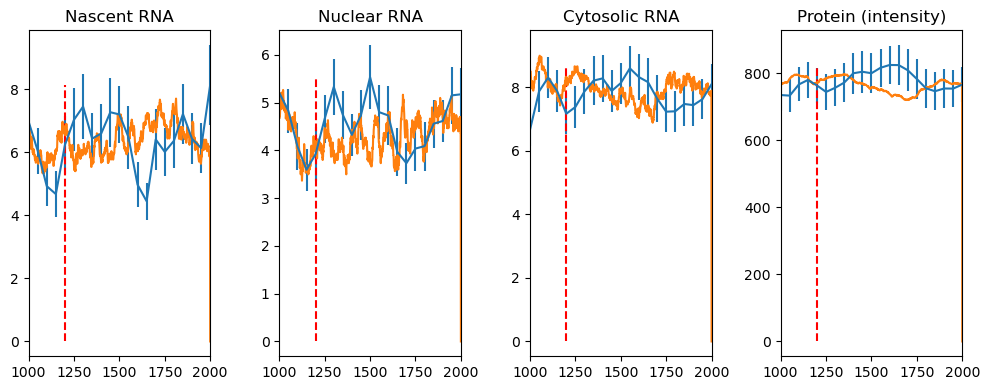

In [51]:
di = [0,0,0,0,0]  # concentrations of the drugs
# [Drug2, Drug4, Drug6, Drug7, Drug10]
ti = [np.inf,np.inf,np.inf,1200,np.inf] # times at which the drugs are added
# [Drug2, Drug4, Drug6, Drug7, Drug10]
x0 = np.array([6.8, 4.6, 8.5, 880]) # initial conditions

# Parameters
# pars = {'k1': 0.003, 'k2': 0.019, 'k3': 0.0162, 'k4': 0.9610, 'k5': 0.01, 'k6': 0.009, 'k7': 0.0109} # NoDrug
pars = {'k1': 0.003, 'k2': 0.019, 'k3': 0.0162, 'k4': 0.9610, 'k5': 0.01, 'k6': 0.009, 'k7': 0.0109}

# Species dictionary - for plotting
speciesDict = {'Nascent':0, 'Nuclear':1, 'Cytoplasmic':2, 'Protein':3}  # how to map your species to the data 

# The stoichiometry matrix
S = np.array([[1,-1,0,0,0,0,0],
              [0,1,-1,0,0,0,-1],
              [0,0,1,0,0,-1,0],
              [0,0,0,1,-1,0,0]])


# Propensity functions
def W_ODE(x,t,pars,di,ti):
    return np.array([np.array([0.1209])*(t<ti[2]) + pars['k1']*(t>=ti[2]),
                     pars['k2']*x[0],
                     (0.0162*(t<ti[0]) + pars['k3']*(t>=ti[0]))*x[1],
                     (0.9610*(t<ti[1]) + pars['k4']*(t>=ti[1]))*x[2],
                     (0.01*(t<ti[4]) + pars['k5']*(t>=ti[4]))*x[3],
                     (0.009*(t<ti[3]) + pars['k6']*(t>=ti[3]))*x[2],
                     (0.0109*(t<ti[3]) + pars['k7']*(t>=ti[3]))*x[1]])

def W_SSA(x,t,pars,di,ti):
    return np.array([0.1209*(t<ti[2]) + pars['k1']*(t>=ti[2]),
                     pars['k2']*x[0],
                     (0.0162*(t<ti[0]) + pars['k3']*(t>=ti[0]))*x[1],
                     (0.9610*(t<ti[1]) + pars['k4']*(t>=ti[1]))*x[2],
                     (0.01*(t<ti[4]) + pars['k5']*(t>=ti[4]))*x[3],
                     (0.009*(t<ti[3]) + pars['k6']*(t>=ti[3]))*x[2],
                     (0.0109*(t<ti[3]) + pars['k7']*(t>=ti[3]))*x[1]])

drugNumber = 7
drug_conc = 100
compare_model_to_data(pars, di, ti, x0, drugNumber, speciesDict, drug_conc, model='SSA',ntraj=30)